# $ZEKROM$
$\text{Zonal Error-bound K-dimensional Reduced Order Models}$




$\text{Real title: Error control for reduced order models (a posteriori error estimator)}$

**SENZA GREEDY**

In [600]:
# global variables
bc_str =  "mu1 * x[0] + mu2 * x[1]"
a_str = "1 + mu1*((x[0]>=0)-(x[0]<0)) + mu2*((x[1]>=0)-(x[1]<0))"



In [601]:
#@title import dependencies

# Installing FEniCS (dolfin) on the Google Colab servers
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
from dolfin import *

# Setting some plotting styles
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

# Importing some libraries
from dolfin import * # This is the core of FEniCS and it contains all the FEM functions we will need
from ufl_legacy.geometry import * # This helps in designing geometries
from ufl_legacy import triangle
from dolfin.cpp.mesh import *     # This handles meshes
from mshr import *                # This generates meshes

import numpy as np
from scipy.linalg import svd
import scipy

from IPython.display import clear_output

def del_prints():
    clear_output(wait=True)
    print('Done!')
del_prints()

Done!


###pipeline

1. Definizione del problema fisico
    - Problema ellittico parametrizzato (es. Poisson, conduzione, elasticità).
      - usiamo Poisson
    - Condizioni al bordo di Dirichlet non omogenee, eventualmente con una lifting function affine nel parametro.
    - Assicurarsi che sia ammissibile una decomposizione affina.

2. Implementazione base (truth model) \
  - FEM 2D con FEniCS.
  - Parametrizza uno o più aspetti del problema (coefficiente diffusivo, condizioni al bordo, forma del dominio...).

3. Costruzione del modello ridotto tramite POD o Greedy\
  - Offline stage
    - Costruzione snapshot: risolvi il problema per un insieme di parametri.
    - Costruisci la base ridotta:
      - POD: tramite SVD degli snapshot.
      - Greedy: usa un estimatore dell’errore a posteriori (da Cap. 4).
    - Ortonormalizzazione delle basi (es. Gram-Schmidt).
    - Precomputazione della decomposizione affine (matrici ridotte Aq_rb, vettori fq_rb...).

  - Online stage
    - Per ogni nuovo parametro:
    - Assemblaggio rapido della matrice ridotta.
    - Soluzione del sistema ridotto.
    - Calcolo dell’output e dell’error estimator.

4. Analisi dell’errore e certificazione\
Validare il modello ridotto e l'estimatore.
  - Plot e analisi dei risultati
  - Errore vs. numero di basi ridotte.
  - Error estimator vs. numero di basi.
  - Fissato N: errore e stimatore al variare del parametro.
  - Effetto della costante di coercività (confronta stime conservative vs. reali).
  - Indice di effectivity dell’estimatore.

5. Analisi computazionale\
Dimostrare i vantaggi del modello ridotto.
  - Benchmark di tempo
  - Tempo medio di una simulazione “truth” vs. ridotta.
  - Calcolo dello speedup.
  - Mostra la scalabilità con il numero di parametri.

## Problema fisico

Definiamo un problema fisico concreto su cui applicare la riduzione di ordine con controllo dell’errore.

Consideriamo l'equazione di Poisson 2D. la **forma forte** è descritta dal sistema

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
u(x;\mu) = g(x;\mu) & \text{su } \partial \Omega
\end{cases}
$$

e, dato $\mu = (\mu_1, \mu_2) \in \mathcal{P} $, scegliamo:

- Diffusività:$\quad a(x; \mu) = 1 $\
(affine rispetto a $\mu \ \Rightarrow$ utile per la riduzione)

- Dirichlet's non-homogeneus BC:$\quad g(x;\mu) = \mu_1 x_1 + \mu_2 x_2 $ (per ora) \
(affine rispetto a $\mu \ \Rightarrow$ lifting facile)

- Forzante (termine sorgente):$\quad f(x) = 1 $

\
Per gestire la non omogeneità delle condizioni al bordo utilizziamo una funzione **"Lifting"** per ricondurci al problema omogeneo, quindi:
$$
u_{\text{lift}} := g(x;\mu) \text{ su } \partial\Omega
$$
ora, definendo $ \tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) $ otteniamo che $ \tilde{u} $ risolve il seguente sistema **omogeneo**:

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla \tilde{u}(x;\mu)) = - \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
\tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) = g(x;\mu) - g(x;\mu) = 0 & \text{su } \partial \Omega
\end{cases}
$$

\
A questo punto possiamo passare alla **forma debole**, cioè:
Trova $\tilde{u}(\mu) \in H_0^1(\Omega)$ tale che:

$$
\int_\Omega a(x;\mu) \nabla \tilde{u} \cdot \nabla v \ dx + \int_\Omega a(x;\mu) \nabla u_{\text{lift}} \cdot \nabla v \ dx = \int_\Omega f v \ dx,  \quad \forall v \in H_0^1(\Omega)
$$
(ricordando che $ u = \tilde{u} + u_{lift} $)


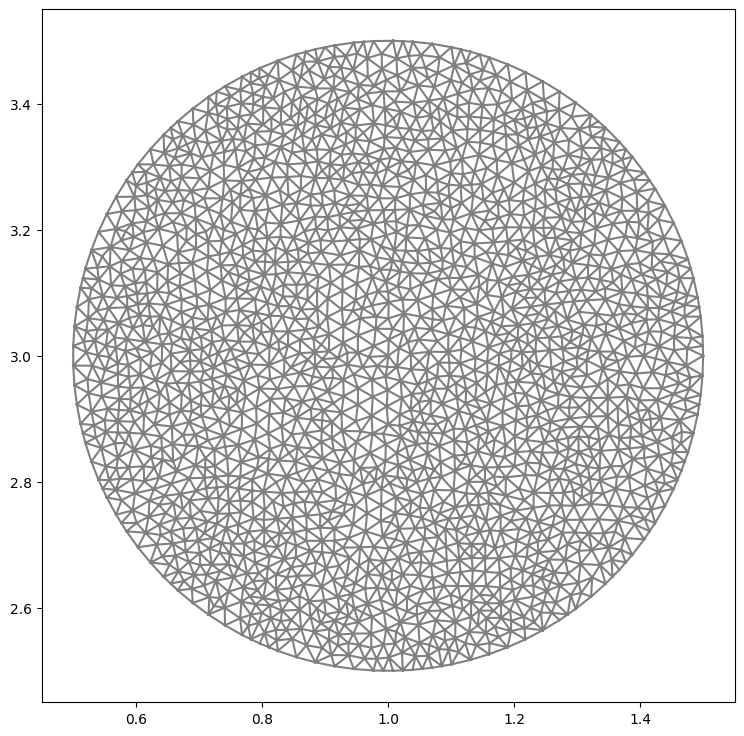

In [602]:
#@title Definizione della geometria $\Omega$
# costruiamo la nostra geometria e generiamo la mesh con circa
# 32 elementi per lato (triangoli di default)
Omega = Circle(Point(1, 3.0),0.5)

mesh = generate_mesh(Omega, 32)
plot(mesh)

In [603]:
#@title Definiamo $ \langle \varphi_i \rangle $  e  $ V_h $ con $ \varphi_i \in \mathbb{P}^1 $
# definiamo le nostre funzioni di base (lagrangiane) sul nostro elemento finito
V_element = FiniteElement('Lagrange', triangle, 1)
V = FunctionSpace(mesh, V_element) # = V_h
del_prints()

Done!


In [604]:
#@title $v$ ed $u$
# a questo punto:
# definiamo le funzioni trial che useremo nel posto dell'incognita u del sistema lineare
# definiamo le funzioni test con il quale testiamo il problema
u = TrialFunction(V) # corrispondono alle colonne del sistema
v = TestFunction(V)  # corrispondono alle righe del sistema

In [605]:
#@title Parametro $\mu$
mu1 = Constant(1.0)
mu2 = Constant(1.0)
a,b = -2,2
aa, bb = abs(a), abs(b)
m1,m2 = abs(bb-aa)+0.5, abs(bb-aa)-0.15

mu1.assign(m1)
mu2.assign(m2)

In [606]:
#@title Diffusività
a_expr = Expression(a_str, degree=1, mu1=mu1, mu2=mu2)

In [607]:
#@title Boundary conditions
# definiamo prima la nostra funzione g
g_expr = Expression(bc_str, degree=2, mu1=mu1, mu2=mu2)
BC = DirichletBC(V, g_expr, "on_boundary")

print("usiamo condizioni al bordo g = " + bc_str)

usiamo condizioni al bordo g = mu1 * x[0] + mu2 * x[1]


### Considerazioni teoriche

Il problema è **coercivo** (Poisson su dominio limitato con $a(x;\mu) \geq 0.1$) \
- Ricordiamo che:\
data una forma bilineare $a(u,v;\mu)$ diciamo che questa è coerciva se $a(u,v;\mu) \geq \alpha(\mu) \ ||v||^2_{H_0^1}$ con $\alpha(\mu)$coefficiente di coercività.
- in altre parole:
  - $a(\cdot,\cdot;\mu)$ controlla la norma $ ||v||$
  - Nessuna "direzione" di $v$ può sfuggire al controllo (nessuna degenerazione)

\
Nel nostro caso abbiamo:

1. $a(x;\mu) \geq \underline{a} > 0$ per ogni $x \in \Omega$, $\mu \in \mathcal{P}$  
   - $ a(x;\mu) = 1 \geq 1 \Rightarrow \alpha(\mu) \geq 1$

2. Il dominio $\Omega$ è limitato e regolare, quindi:
   - Poincaré: $\|v\|_{L^2} \leq C \|\nabla v\|$ \
   $\Rightarrow$ la norma $H^1_0$ è equivalente a $\|\nabla v\|$

3. La forma bilineare è:
   $$
   a(u,v;\mu) = \int_\Omega a(x;\mu) \nabla u \cdot \nabla v \, dx
   $$
   che è **simmetrica**, **positiva definita**, e **uniformemente ellittica**

\
Otteniamo quindi:
- Esistenza e unicità della soluzione per il teorema di Lax-Milgram
- Stabilità numerica per Finite Element Method (FEM)
- Errori stimabili a posteriori
- RBM certificabile cioè è possibile stimare l’errore tra soluzione ridotta e completa
- Convergenza garantita: Greedy converge rapidamente se l'errore è controllato da coercività

\

Obiettivo nel contesto RBM

- Costruire base ridotta (POD o greedy)
- Stimare errore e certificare $\eta(\mu)$
- Visualizzare:
  - errore vs. $N$ basi
  - errore/estimatore vs. parametro
  - speedup vs. full FEM

## FEM

A questo punto riscriviamo la PDE
$$
\begin{cases}
- \Delta u = f \quad & \text{in} \ \Omega \\
u = g \quad & \text{in} \ \partial \Omega
\end{cases}
$$
come
$$
u = w + u_{lift}
$$
dove $\quad w|_{\partial \Omega} = 0 \quad \text{ e } \quad u_{lift}|_{\partial \Omega} = g$
per poi risolvere la PDE usando
$$
- \Delta w = f + \Delta u_{lift} \quad \text{in} \ \Omega, \quad w|_{\partial \Omega} = 0
$$

In [608]:
#@title Calcolo LHS e RHS per $u_{lift}$ (problema con lifting)

# definiamo la funzione lifting u_lift, tc u_lift = g su ∂Ω
u_lift = TrialFunction(V) # soddisfa la BC g

# risolviamo -Δ(u_lift) = 0 with u_lift = g on ∂Ω
lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
rhs_lift = Constant(0.0) * v * dx

LHS_lift = assemble(lhs_lift)
RSH_lift = assemble(rhs_lift)

BC.apply(LHS_lift)
BC.apply(RSH_lift)

del_prints()
print(type(LHS_lift), type(u_lift), type(RSH_lift))

Done!
<class 'dolfin.cpp.la.Matrix'> <class 'dolfin.function.argument.Argument'> <class 'dolfin.cpp.la.Vector'>


In [609]:
#@title Risoluzione per $u_{lift}$
ul_sol = Function(V)
solve(LHS_lift, ul_sol.vector(), RSH_lift)

1

In [610]:
#@title Calcolo LHS e RHS per $w:=\tilde{u}$ (problema omogeneo)

#Right-hand side del problema omogeneo f + Δ(u_lift) = f - div * ( grad(u_lift) )
f = Constant(1.0)
rhs_expr = f -div(grad(ul_sol))

# Risolvo per w in: -Δw = f + Δ(u_lift), w = 0 su ∂Ω
w = TrialFunction(V)
lhs_w = a_expr * inner(grad(w), grad(v)) * dx
rhs_w = rhs_expr * v * dx

LHS_w = assemble(lhs_w)
RHS_w = assemble(rhs_w)

zero_BC = DirichletBC(V, 0.0, "on_boundary")
zero_BC.apply(LHS_w)
zero_BC.apply(RHS_w)

del_prints()

Done!


In [611]:
#@title Risoluzione per $w$
w_sol = Function(V)
solve(LHS_w, w_sol.vector(), RHS_w)

1

In [612]:
#@title unione dei due risultati
# calcolo soluzione finale: u = w + u_lift
u_sol = Function(V)
u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

### Plot delle soluzioni $ u_{lift}, \, w, \, u $

In [613]:
#@title plotting function
def plottiaml(sol_list, titles=None):
    n = len(sol_list)
    if n == 0:
        print("La lista delle soluzioni è vuota.")
        return

    n_cols = min(n, 3)           # massimo 3 colonne
    n_rows = int(np.ceil(n / 3)) # tante righe quante servono

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    if n_rows == 1:
        axes = np.atleast_1d(axes)
    else:
        axes = axes.flatten()

    for i in range(n):
        plt.sca(axes[i])
        p = plot(sol_list[i])
        if titles is not None and i < len(titles):
            axes[i].set_title(titles[i])
        plt.colorbar(p)

    # Disattiva subplot vuoti
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    del_prints()
    plt.show()

Done!


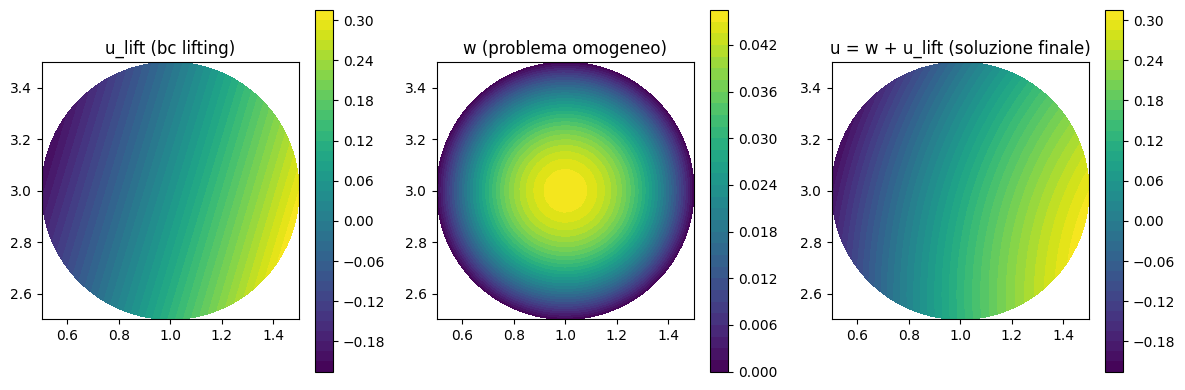

mu_1 = 0.5  ;  mu_2 = -0.15


In [614]:
plottiaml([ ul_sol              ,  w_sol                 ,  u_sol                             ],
          ["u_lift (bc lifting)", "w (problema omogeneo)", "u = w + u_lift (soluzione finale)"])
print('mu_1 =',float(mu1), ' ; ','mu_2 =', float(mu2))

In [615]:
N_dofs = len(u_sol.vector())
N_dofs

2032

### Truth solver

In [616]:
#@title Truth solver (compressione di tutto in una funzione)
def solve_for(V, mu1_val,mu2_val):

    u = TrialFunction(V)
    v = TestFunction(V)

    mu1 = Constant(1.0)
    mu2 = Constant(1.0)
    mu1.assign(mu1_val)
    mu2.assign(mu2_val)
    g_expr = Expression(bc_str, degree=2, mu1=mu1, mu2=mu2)
    a_expr = Expression(a_str , degree=1, mu1=mu1, mu2=mu2)
    BC = DirichletBC(V, g_expr, "on_boundary")

    u_lift = TrialFunction(V)
    lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
    rhs_lift = Constant(0.0) * v * dx

    LHS_lift = assemble(lhs_lift)
    RSH_lift = assemble(rhs_lift)
    BC.apply(LHS_lift)
    BC.apply(RSH_lift)
    ul_sol = Function(V)
    solve(LHS_lift, ul_sol.vector(), RSH_lift)

    f = Constant(1.0)
    rhs_expr = f + -div(grad(ul_sol))
    w = TrialFunction(V)
    lhs_w = a_expr * inner(grad(w), grad(v)) * dx
    rhs_w = rhs_expr * v * dx

    LHS_w = assemble(lhs_w)
    RHS_w = assemble(rhs_w)

    zero_BC = DirichletBC(V, 0.0, "on_boundary")
    zero_BC.apply(LHS_w)
    zero_BC.apply(RHS_w)

    w_sol = Function(V)
    solve(LHS_w, w_sol.vector(), RHS_w)

    u_sol = Function(V)
    u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

    del_prints()
    return ul_sol.copy(deepcopy=True), w_sol.copy(deepcopy=True), u_sol.copy(deepcopy=True)

In [617]:
ul_sol, w_sol, u_sol = solve_for(V, mu1_val = m1 ,
                                    mu2_val = m2)
#plottiaml([ul_sol, w_sol, u_sol]) # per controllare che dia lo stesso risultato in caso di diffidenza

Done!


##RBM

### Offline stage

Costruiamo il **manifold delle soluzioni**:

$$
\mathcal{M}_\delta = \{ u_\delta(\mu) \mid \mu \in \mathcal{P} \}
$$

dove ogni $u_\delta(\mu)$ è ottenuta risolvendo il problema completo per un parametro $\mu = (\mu_1, \mu_2)$ nel sottospazio scelto dallo spazio dei parametri. Queste soluzioni si chiamano **snapshots**.


In [618]:
#@title $\mu$ grid
# costruiamo la griglia di parametri con i quali risolveremo i nostri sistemi
mus = np.array([[m_1, m_2] for m_1 in np.linspace(a, b, 11) for m_2 in np.linspace(a, b, 11)])
M = len(mus)
M

121

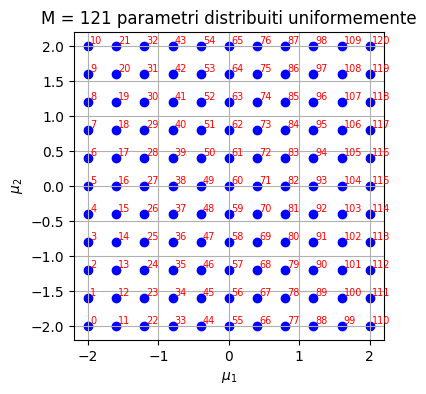

In [619]:
#@title visualizzazione
plt.figure(figsize=(4, 4))
plt.scatter(mus[:, 0], mus[:, 1], c='blue', label='Parametri selezionati')
for k, (x, y) in enumerate(mus):
    plt.text(x + 0.03, y + 0.03, str(k), fontsize=7, color='red')
plt.grid(True)
plt.title(f"M = {M} parametri distribuiti uniformemente")
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.show()

In [620]:
#@title Costruiamo la matrice $U$ di snapshots con dimensionalità $ \ N_{dofs} \times M$ con $N_{dofs} := N_{\delta}$
U = np.zeros(shape=(N_dofs,M))
j = 0
np.random.seed(42)
np.random.shuffle(mus)
for m_1, m_2 in mus:
    _, _, u_sol = solve_for(V, m_1, m_2)
    U[:,j]=u_sol.vector().get_local()
    j+=1

Done!


In [621]:
#@title visualizziamo le soluzioni trovate (se vogliamo)
we_want = False
#we_want = True

# siamo passati da  u_sol -----------------------------> u_sol.vector() -------------> u_sol.vector().get_local())
#        quindi da 'dolfin.function.function.Function'->'dolfin.cpp.la.PETScVector'->'numpy.ndarray'
# torniamo da class 'numpy.ndarray a class 'dolfin.function.function.Function'>

if we_want:
    i1,i2,i3,i4,i5,i6,i7,i8,i9 = np.random.randint(0, M, 9)
    u1, u2, u3, u4, u5, u6, u7, u8, u9 = Function(V), Function(V), Function(V), Function(V), Function(V), Function(V), Function(V), Function(V), Function(V)
    u1.vector().set_local(U[:,i1]); u1.vector().apply("insert")
    u2.vector().set_local(U[:,i2]); u2.vector().apply("insert")
    u3.vector().set_local(U[:,i3]); u3.vector().apply("insert")
    u4.vector().set_local(U[:,i4]); u4.vector().apply("insert")
    u5.vector().set_local(U[:,i5]); u5.vector().apply("insert")
    u6.vector().set_local(U[:,i6]); u6.vector().apply("insert")
    u7.vector().set_local(U[:,i7]); u7.vector().apply("insert")
    u8.vector().set_local(U[:,i8]); u8.vector().apply("insert")
    u9.vector().set_local(U[:,i9]); u9.vector().apply("insert")

    plottiaml([u1, u2, u3, u4, u5, u6, u7, u8, u9])

else: print('non vogliamo')

non vogliamo


Ora utilizziamo la **Proper Orthogonal Decomposition (POD)** per ottenere una base ridotta ottimale nel senso $L^2$.

Si considera la matrice dei dati:

$$
U = [u_\delta(\mu_1), u_\delta(\mu_2), \ldots, u_\delta(\mu_M)] \in \mathbb{R}^{N_\delta \times M}
$$

e si effettua la decomposizione SVD:

$$
U = W \Sigma V^T
$$

Gli autovettori singolari sinistri $\xi_i$ (colonne di $U_{svd} := W$) sono le funzioni base e proendendo i primi $K$ formiamo la base ridotta:

$$
V_{\text{rb}} = \text{span}\{\xi_1, \ldots, \xi_K\}
$$

che minimizza l'errore medio tra gli snapshot e le loro proiezioni.


In [622]:
#@title Eseguiamo la SVD e riduciamo
U_mean = np.mean(U, axis=1, keepdims=True)
U_centered = U - U_mean
U_svd, S, VT = svd(U_centered, full_matrices=False)
print(U.shape)

# Numero di funzioni base ridotte da conservare
K = 5
RB = U_svd[:, :K]  # colonne = basi ridotte, N_dofs x K

print(f"Costruito spazio ridotto con K = {K} basi su {U.shape[0]} DOF originali.")
print(f'la dimensione della nostra base ridotta è {RB.shape}')

(2032, 121)
Costruito spazio ridotto con K = 5 basi su 2032 DOF originali.
la dimensione della nostra base ridotta è (2032, 5)


In [623]:
#@title se vogliamo precomputare una base per trovare $u_{lift}$
def precompute_lifting_basis(V):
    """Compute the two lifting solutions u1 (for x[0]) and u2 (for x[1]) offline."""
    v = TestFunction(V)
    u_trial = TrialFunction(V)

    a_expr = Expression("2.0", degree=1)  # coefficiente 'a' senza mu, costante
    a_form = a_expr * inner(grad(u_trial), grad(v)) * dx
    zero_rhs = Constant(0.0) * v * dx

    # Lifting 1: Dirichlet BC = x[0]
    g1 = Expression("x[0]", degree=1)
    bc1 = DirichletBC(V, g1, "on_boundary")
    A1 = assemble(a_form)
    b1 = assemble(zero_rhs)
    bc1.apply(A1, b1)
    u1 = Function(V)
    solve(A1, u1.vector(), b1)

    # Lifting 2: Dirichlet BC = x[1]
    g2 = Expression("x[1]", degree=1)
    bc2 = DirichletBC(V, g2, "on_boundary")
    A2 = assemble(a_form)
    b2 = assemble(zero_rhs)
    bc2.apply(A2, b2)
    u2 = Function(V)
    solve(A2, u2.vector(), b2)

    return u1, u2

u1_lift, u2_lift = precompute_lifting_basis(V)


###Online stage

Dato il sottospazio ridotto $V_{\text{rb}} = \text{span}\{\xi_1, \dots, \xi_K\}$, si cerca $u_{\text{rb}}(\mu) \in V_{\text{rb}}$ tale che soddisfi la **proiezione di Galerkin**, cioè tale che:

$$
a(u_{\text{rb}}(\mu), v; \mu) = f(v; \mu) \quad \forall v \in V_{\text{rb}}
$$

In pratica, il problema viene proiettato sulla base ridotta, riducendo drasticamente il costo computazionale. come facciamo?

Data una nuova coppia di parametri $\mu = (\mu_1, \mu_2)$, vogliamo:

1. Costruire il lifting per soddisfare le condizioni al bordo non omogenee.
2. Proiettare il problema variazionale nello spazio ridotto.
3. Risolviamo un sistema lineare piccolo di dimensione $K \times K$.
4. Ricostruiamo la soluzione approssimata:

$$
u_{rb}(x; \mu) \approx u_{lift}(x; \mu) + \sum_{i=1}^K c_i(\mu) \xi_i(x)
$$


Ora servono:

- La matrice ridotta:
  $ A_{\text{red}} = \Phi^T A \Phi $
- Il termine noto ridotto:
  $ b_{\text{red}} = \Phi^T (b - A u_L) $

In [624]:
#@title funzione per il calcolo del lifting
def compute_lift(V, mu1_val, mu2_val):

    u_lift = TrialFunction(V)
    v      = TestFunction(V)

    mu1 = Constant(mu1_val)
    mu2 = Constant(mu2_val)
    a_expr = Expression(a_str , degree=1, mu1=mu1, mu2=mu2)
    g_expr = Expression(bc_str, degree=2, mu1=mu1, mu2=mu2)
    BC = DirichletBC(V, g_expr, "on_boundary")

    a_form = a_expr * inner(grad(u_lift), grad(v)) * dx
    L_form = Constant(0.0) * v * dx

    A = assemble(a_form)
    b = assemble(L_form)
    BC.apply(A, b)

    u_lift_sol = Function(V)
    solve(A, u_lift_sol.vector(), b)

    del_prints()
    return u_lift_sol


def compute_lift_affine(mu1_val, mu2_val, u1, u2, V):
    """Combine precomputed lifting functions linearly."""
    u_lift = Function(V)
    u_lift.vector()[:] = mu1_val * u1.vector() + mu2_val * u2.vector()
    return u_lift

In [625]:
#@title funzione per calcolo di $u_{rb}$
def solve_online(V, RB, mu1_val, mu2_val):

    mu1 = Constant(1.0)
    mu2 = Constant(1.0)
    mu1.assign(mu1_val)
    mu2.assign(mu2_val)

    # Calcolo del lifting
    u_lift = compute_lift(V, mu1_val, mu2_val)
    # se vogliamo calcolare anche u_lift
    #u_lift = compute_lift_affine(mu1_val, mu2_val, u1_lift, u2_lift, V)

    # Assemblaggio residuo modificato
    u = TrialFunction(V)
    v = TestFunction(V)

    a_expr = Expression(a_str , degree=1, mu1=mu1, mu2=mu2)
    f = Constant(1.0)
    rhs_expr = f - div(grad(u_lift))

    a_form = a_expr * inner(grad(u), grad(v)) * dx
    f_form = rhs_expr * v * dx

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    A, F = assemble_system(a_form, f_form, bc)

    # conversione a matrice scipy
    A_csr = as_backend_type(A).mat().getValuesCSR()
    A_mat = scipy.sparse.csr_matrix((A_csr[2], A_csr[1], A_csr[0]))
    f_vec = F.get_local()

    # Proiezione nel sottospazio ridotto
    A_rb = RB.T @ A_mat @ RB
    f_rb = RB.T @ f_vec
    u_rb_coeffs = np.linalg.solve(A_rb, f_rb)

    # Ricostruzione soluzione finale
    u_rb_vec = RB @ u_rb_coeffs
    u_high_vec = u_rb_vec #+ U_mean.flatten()

    # Aggiunta anche del lifting
    u_total = Function(V)
    u_total.vector()[:] = u_high_vec + u_lift.vector()

    del_prints()
    return u_total

Confrontiamo ora la soluzione completa vista prima con $\mu_1 = 0.2$ e $\mu_2 = 0.15$

Done!


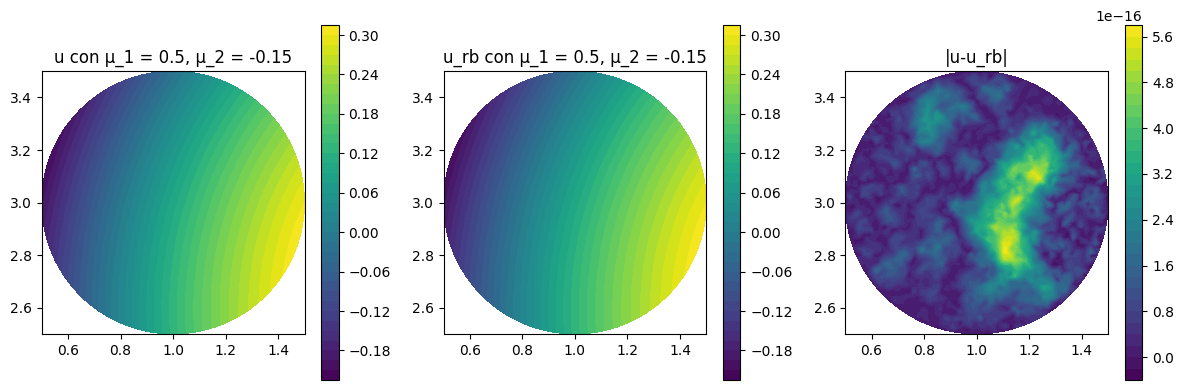

l'errore relativo è 1.0888935549497168e-15 
la differenza massima è 5.828670879282072e-16 
la differenza minima è 0.0 


In [626]:
#@title plot comparazione
_, _, u_full = solve_for(V, m1, m2)
u_rb = solve_online(V, RB,  m1, m2)
rel_err = np.linalg.norm(u_rb.vector().get_local() - u_full.vector().get_local()) / np.linalg.norm(u_full.vector().get_local())

r = np.abs(u_full - u_rb)
difmax = np.max(np.abs(u_rb.vector().get_local() - u_full.vector().get_local()))
difmin = np.min(np.abs(u_rb.vector().get_local() - u_full.vector().get_local()))

plottiaml([u_full, u_rb, r],
          [f'u con μ_1 = {m1}, μ_2 = {m2}', f'u_rb con μ_1 = {m1}, μ_2 = {m2}', f'|u-u_rb|'])
print(f"l'errore relativo è {rel_err} ")
print(f"la differenza massima è {difmax} ")
print(f"la differenza minima è {difmin} ")


Molto bene! ora proviamo a farlo per più parametri cosi vediamo se è solo un caso

In [627]:
#@title funzione calcolo errore relativo per $ \{ \mu_{test}^{(1)},..., \mu_{test}^{(\text{test_size})} \} $  scelti uniformemente
def test_rbm_accuracy(V, RB, test_size=5):

    test_mus = np.random.uniform(-1, 1, (test_size, 2))
    errors = np.zeros((test_size,))

    for i,m in enumerate(test_mus):
        m1,m2 = m
        _, _, u_full = solve_for(V, m1, m2)
        u_rb = solve_online(V, RB, m1, m2)
        errors[i] = np.linalg.norm(u_rb.vector().get_local() - u_full.vector().get_local()) / np.linalg.norm(u_full.vector().get_local())

    # statistiche
    err_mean = np.mean(errors)
    err_max = np.max(errors)
    err_min = np.min(errors)

    print("\nStatistiche errori:")
    print(f"Errore medio   : {err_mean}")
    print(f"Errore massimo : {err_max}")
    print(f"Errore minimo  : {err_min}")

    return test_mus, errors

In [628]:
np.random.seed(42)
test_mus, errors = test_rbm_accuracy(V, RB, test_size=30)

Done!

Statistiche errori:
Errore medio   : 9.410838330273646e-16
Errore massimo : 3.789692701820666e-15
Errore minimo  : 5.555716909548456e-17


Perfetto!

##Min-Theta

Stima dell'errore tramite residuo:

Per un problema coercivo si può stimare l'errore nella norma energetica:

$$
\| u_\delta(\mu) - u_{\text{rb}}(\mu) \|_V \leq \frac{ \| r(\cdot; \mu) \|_{V'} }{ \sqrt{ \alpha_{\text{LB}}(\mu) } }
$$

dove $r(\cdot; \mu)$ è il **residuo**:

$$
r(v; \mu) = f(v; \mu) - a(u_{\text{rb}}(\mu), v; \mu)
$$

e $\alpha_{\text{LB}}(\mu)$ è un lower bound della costante di coercività. In molti casi può essere noto o stimato tramite **min-theta** o **SCM**.


In [629]:
#@title Calcolo delle costanti di coercività per gli snapshot
def compute_coercivity_constants(V, mus):
    """
    α(μ) = λ_min( A(μ), M )  con Dirichlet su ∂Ω
    Restituisce un array di lunghezza len(mus)
    """
    alphas = np.zeros(len(mus))
    u, v = TrialFunction(V), TestFunction(V)
    bc   = DirichletBC(V, Constant(0.0), "on_boundary")

    for i, (mu1_val, mu2_val) in enumerate(mus):
        mu1 = Constant(mu1_val);  mu2 = Constant(mu2_val)
        a_expr = Expression(a_str, degree=1, mu1=mu1, mu2=mu2, domain=mesh)

        A  = assemble( a_expr*inner(grad(u), grad(v))*dx )
        M  = assemble( inner(grad(u), grad(v))*dx + inner(u, v)*dx )

        # applico Dirichlet sia ad A sia a M
        bc.apply(A);  bc.apply(M)

        # converto in csr_matrix (SciPy)
        ia, ja, dataA = as_backend_type(A).mat().getValuesCSR()
        iaM, jaM, dataM = as_backend_type(M).mat().getValuesCSR()
        n = V.dim()
        A_csr = scipy.sparse.csr_matrix((dataA, ja, ia),  shape=(n, n))
        M_csr = scipy.sparse.csr_matrix((dataM, jaM, iaM), shape=(n, n))

        # autovalore minimo generalizzato (piccolo in modulo)
        eigval = scipy.sparse.linalg.eigsh(
                    A_csr, k=1, M=M_csr,
                    which='SM', tol=1e-9, return_eigenvectors=False)[0]
        alphas[i] = eigval
        print(f"μ = ({mu1_val:+.2f}, {mu2_val:+.2f}) → α(μ) = {eigval:.6e}")

    return alphas




#@title Calcolo dei coefficienti theta
def compute_theta_coefficients(mus, alphas):
    """
    Calcola i coefficienti theta che rappresentano la decomposizione affina di α(μ)
    """
    # Costruiamo la matrice del sistema lineare per la regressione

    M = len(mus)
    A = np.zeros((M, 3))
    b = np.zeros(M)

    for i, (mu1, mu2) in enumerate(mus):
        A[i, 0] = 1.0
        A[i, 1] = mu1
        A[i, 2] = mu2
        b[i] = alphas[i]

    # Risolviamo il sistema ai minimi quadrati
    theta, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)

    print("\nCoefficienti theta ottenuti:")
    print(f"θ0 = {theta[0]:.6f}")
    print(f"θ1 = {theta[1]:.6f}")
    print(f"θ2 = {theta[2]:.6f}")
    print(f"Residui: {residuals}")

    return theta

In [630]:
def compute_alpha_LB(mu):
    mu1, mu2 = mu
    return max(2 - 0.5*abs(mu1), 0.1)

In [631]:
# @title Solve Online
def solve_online_with_error(V, RB, mu1_val, mu2_val):
    """
    Risolve il problema ridotto, calcola lo stimatore con norma duale
    corretta (su w = u - u_lift) e confronta con l'errore effettivo.
    """
    # 1) soluzione ridotta
    u_rb = solve_online(V, RB, mu1_val, mu2_val)

    # 2) bound di coercività analitico
    alpha_LB = compute_alpha_LB([mu1_val, mu2_val])

    # 3) parametri, diffusività, lifting
    mu1 = Constant(mu1_val)
    mu2 = Constant(mu2_val)
    a_expr  = Expression(a_str, degree=1, mu1=mu1, mu2=mu2, domain=mesh)
    u_lift  = compute_lift(V, mu1_val, mu2_val)

    # 4) forme variazionali
    v = TestFunction(V)
    w = TrialFunction(V)

    a_form   = a_expr * inner(grad(w), grad(v)) * dx
    rhs_expr = Constant(1.0) - div(grad(u_lift))
    f_form   = rhs_expr * v * dx

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    A, F = assemble_system(a_form, f_form, bc)

    # 5) Residuo
    w_rb_vec = u_rb.vector() - u_lift.vector()
    residual = F - A * w_rb_vec

    # 6) norma duale del residuo
    z = residual.copy()
    solver = PETScKrylovSolver("cg", "hypre_amg")
    solver.set_operator(A)
    solver.parameters.update({"relative_tolerance": 1e-10,
                              "absolute_tolerance": 1e-12,
                              "monitor_convergence": False})
    solver.solve(z, residual)
    residual_dual_norm = np.sqrt(residual.inner(z))

    error_estimate = residual_dual_norm / np.sqrt(alpha_LB)

    # 7) errore con il truth solver
    _, _, u_full = solve_for(V, mu1_val, mu2_val)
    true_error = np.linalg.norm(u_rb.vector().get_local()
                                - u_full.vector().get_local()) \
                 / np.linalg.norm(u_full.vector().get_local())

    print(f"\nμ = ({mu1_val:.2f}, {mu2_val:.2f})")
    print(f"α_LB         = {alpha_LB:.6f}")
    print(f"‖r‖_V'       = {residual_dual_norm:.4e}")
    print(f"Stima errore = {error_estimate:.4e}")
    print(f"Errore vero  = {true_error:.4e}")
    print(f"Effectivity  = {error_estimate/true_error:.4f}")

    return u_rb, error_estimate, true_error


In [632]:

# Calcoliamo le costanti di coercività
alphas = compute_coercivity_constants(V, mus)

# Calcoliamo i coefficienti theta
theta = compute_theta_coefficients(mus, alphas)

# Testiamo su alcuni parametri
test_mus = np.array([[0.2, 0.15], [0.5, -0.3], [-0.8, 0.7], [0.9, 0.9], [-1.0, -1.0]])
for mu in test_mus:
    alpha_LB = compute_alpha_LB(mu)


μ = (-0.40, -2.00) → α(μ) = -1.980225e-01
μ = (-0.40, -0.80) → α(μ) = -1.462953e-01
μ = (-2.00, -0.40) → α(μ) = 6.955359e-02
μ = (+0.00, -2.00) → α(μ) = -3.221806e-03
μ = (-1.20, -0.40) → α(μ) = 5.398005e-02
μ = (+0.00, +1.60) → α(μ) = 1.843083e-02
μ = (+0.40, +0.80) → α(μ) = 3.026199e-02
μ = (-2.00, +2.00) → α(μ) = -4.956557e-02
μ = (-0.80, +0.80) → α(μ) = -3.923518e-02
μ = (+1.60, +1.60) → α(μ) = -3.762122e-02
μ = (-1.60, +0.80) → α(μ) = -1.020354e-01
μ = (+0.00, +0.80) → α(μ) = -7.447565e-03
μ = (-1.60, -2.00) → α(μ) = -6.602537e-03
μ = (-0.80, -0.80) → α(μ) = -5.624534e-01
μ = (+1.20, -1.20) → α(μ) = -4.686977e-02
μ = (+2.00, +1.20) → α(μ) = -2.555033e-02
μ = (+2.00, -2.00) → α(μ) = -4.756802e-02
μ = (-2.00, -2.00) → α(μ) = 3.030168e-01
μ = (+1.20, -1.60) → α(μ) = 2.090792e-02
μ = (+1.60, +0.00) → α(μ) = -2.909897e-02
μ = (+0.00, +2.00) → α(μ) = 2.173026e-02
μ = (-0.40, -1.60) → α(μ) = 1.012676e-03
μ = (-1.20, +1.60) → α(μ) = -3.078886e-02
μ = (+0.40, -0.40) → α(μ) = -3.675359e-02


In [633]:
# @title Test finale
np.random.seed(42)
test_mus = np.random.uniform(a, b, (5, 2))

error_estimates = []
true_errors = []

print("\nTest con norma duale:")
for mu1, mu2 in test_mus:
    _, est, true_err = solve_online_with_error(V, RB, mu1, mu2)
    error_estimates.append(est)
    true_errors.append(true_err)

effectivities = np.array(error_estimates) / np.array(true_errors)
print(f"\nIndice di effectivity medio: {np.mean(effectivities):.4f}  (atteso ≈ 1–10)")


Done!

μ = (0.40, 0.83)
α_LB         = 1.797770
‖r‖_V'       = 0.0000e+00
Stima errore = 0.0000e+00
Errore vero  = 6.3183e-17
Effectivity  = 0.0000

Indice di effectivity medio: 0.0000  (atteso ≈ 1–10)
